# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Загрузка данных
df = pd.read_csv('to-modal.csv', parse_dates=['dt'], index_col='dt')

# Выбор целевой переменной
target = df['Цена на арматуру'].dropna()

# Проверка стационарности (например, с помощью теста Дики-Фуллера)
from statsmodels.tsa.stattools import adfuller
result = adfuller(target)
print(f"ADF p-value: {result[1]:.4f}")  # Если p-value > 0.05, ряд нестационарен

ADF p-value: 0.0000


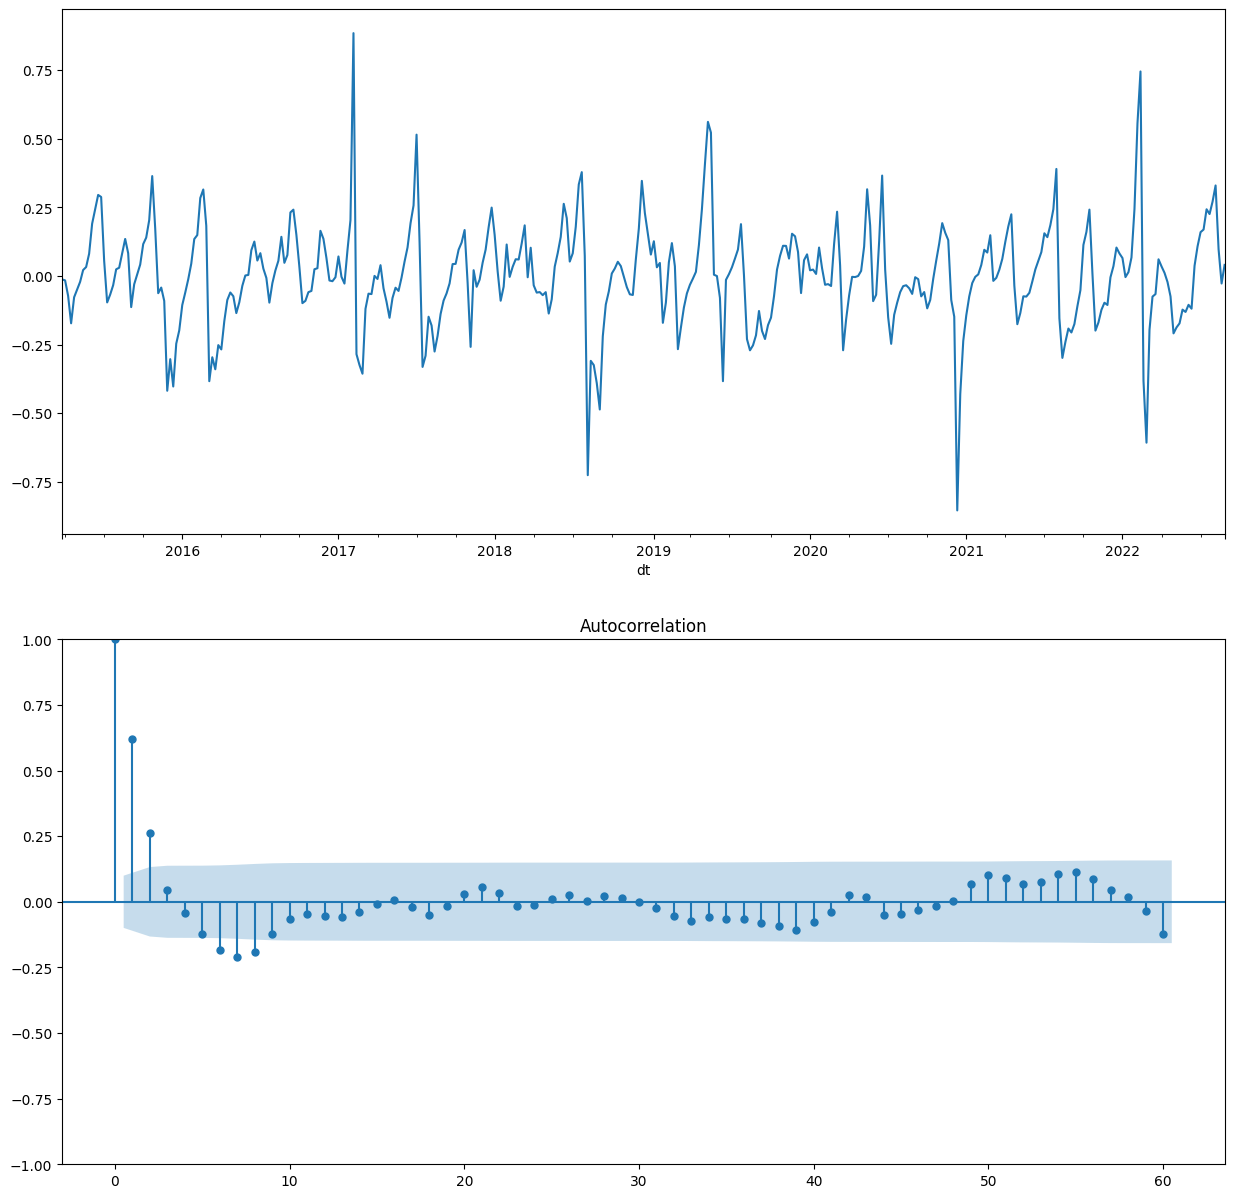

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df['Цена на арматуру'], lags=60, ax=ax[1]);

In [4]:
# Разделение данных
test_size = int(len(target) * 0.2)
train, test = target.iloc[:-test_size], target.iloc[-test_size:]

# Модели

## SARIMA

In [5]:
import warnings
import itertools
warnings.filterwarnings("ignore")

def search_optimal_sarima(time_series, seasonal_cycle):
  order_vals = diff_vals = ma_vals = range(0, 2)
  pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
  seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
      
  smallest_aic = float("inf")
  optimal_order_param = optimal_seasonal_param = None

  for order_param in pdq_combinations:
      for seasonal_param in seasonal_combinations:
          try:
              sarima_model = SARIMAX(time_series,
                                                        order=order_param,
                                                        seasonal_order=seasonal_param,
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)

              model_results = sarima_model.fit()
              if model_results.aic < smallest_aic:
                  smallest_aic = model_results.aic
                  optimal_order_param = order_param
                  optimal_seasonal_param = seasonal_param
          except:
              continue

  print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 12
search_optimal_sarima(train, seasonal_cycle_length)

ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:-333.10660546823397


In [6]:
# Обучение модели
order = (3, 0, 1)  # (p, d, q)
seasonal_order = (2, 1, 0, 12)  # (P, D, Q, S), где S — сезонность

# Создание и обучение модели
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

# Прогноз на тестовой выборке
forecast = results.get_forecast(steps=len(test))
predicted = forecast.predicted_mean
confidence_interval = forecast.conf_int()

## что то с грид серчем

In [9]:
# data = df.asfreq('MS')
# data = data['y']
# data = data.sort_index()

# # Data partition train-test
# # ==============================================================================
# end_train = '2005-06-01 23:59:00'
# print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
# print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# # Plot
# # ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3))
# data.loc[:end_train].plot(ax=ax, label='train')
# data.loc[end_train:].plot(ax=ax, label='test')
# ax.legend();

In [11]:
# # Create and fit a recursive multi-step forecaster (ForecasterAutoreg)
# # ==============================================================================
# forecaster = ForecasterAutoreg(
#                  regressor = RandomForestRegressor(random_state=123),
#                  lags      = 15
#              )

# forecaster.fit(y=data.loc[:end_train])
# forecaster

In [13]:
# # Libraries
# # ==============================================================================
# import pandas as pd
# import matplotlib.pyplot as plt
# from skforecast.model_selection import grid_search_sarimax

# param_grid = {'order': [(12, 0, 0), (12, 2, 0), (12, 1, 0), (12, 1, 1), (14, 1, 4)],
#              'seasonal_order': [(0, 0, 0, 0)],
#              'trend': [None, 'n', 'c']}

# results_grid = grid_search_sarimax(
#     forecaster = forecaster,
#     y = df.loc[:'2006-01-01'],
#     param_grid = param_grid,
#     metric = 'mean_absolute_error',
#     verbose = False,
#     cv=
#     )

# results_grid


## catboost

0:	learn: 0.1741422	test: 0.1925087	best: 0.1925087 (0)	total: 4.05ms	remaining: 4.05s
200:	learn: 0.0327262	test: 0.1430796	best: 0.1423293 (176)	total: 250ms	remaining: 992ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1423292842
bestIteration = 176

Shrink model to first 177 iterations.
MAE: 0.09
MSE: 0.02
RMSE: 0.14
R²: 0.4772


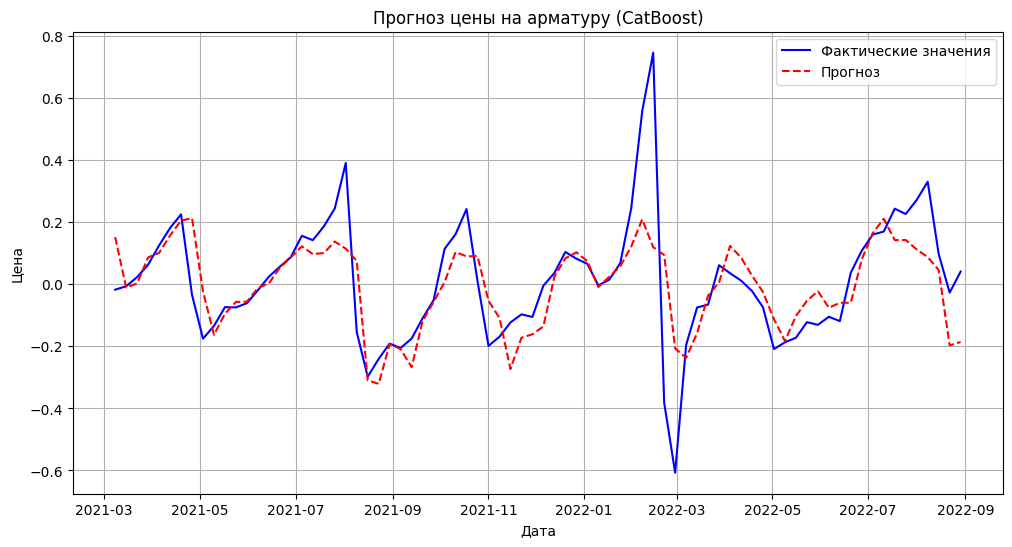

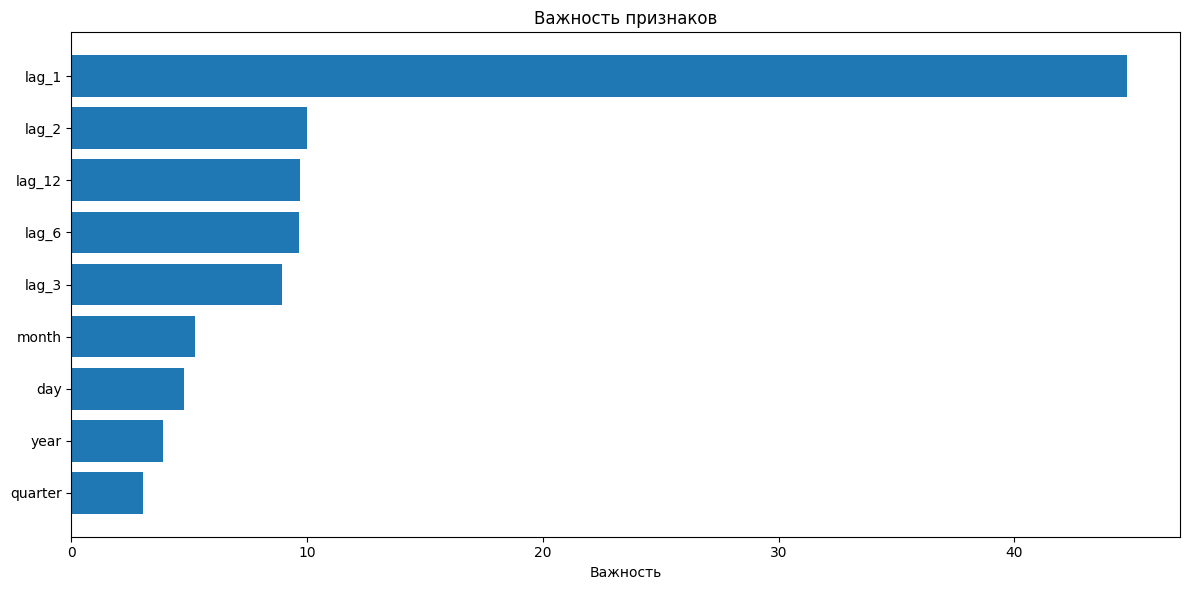

In [24]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

# Предполагаем, что у нас уже есть DataFrame df с данными

# Подготовка данных
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['quarter'] = df.index.quarter 

for lag in [1, 2, 3, 6, 12]:
    df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)

# Выбор признаков и целевой переменной
features = ['year', 'month', 'day', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']
target = 'Цена на арматуру'

# Разделение на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Создание и обучение модели
model = CatBoostRegressor(iterations=1000, 
                          learning_rate=0.1, 
                          depth=6, 
                          loss_function='RMSE',
                          verbose=200)

model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=50)

# Прогнозирование
predictions = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (CatBoost)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

# Важность признаков
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

# Проверка прогноза

ValueError: x and y must have same first dimension, but have shapes (78,) and (77,)

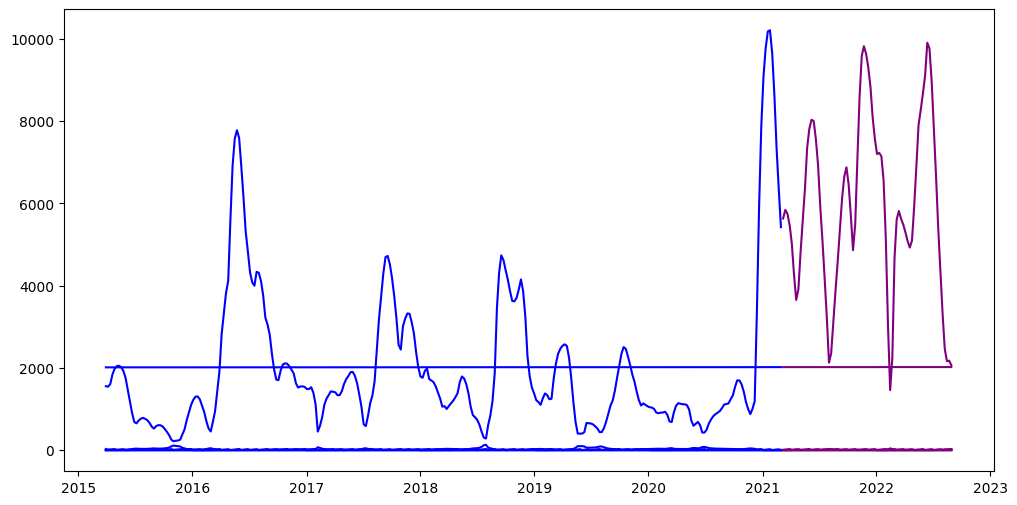

In [15]:
# Визуализация предсказания
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающая выборка', color='blue')
plt.plot(test.index, test, label='Фактические значения', color='purple')
plt.plot(test.index, predicted, label='Прогноз', color='red', linestyle='--')
plt.fill_between(test.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.2)
plt.title('Прогноз цены на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Метрики
mae = mean_absolute_error(test, predicted)
mse = mean_squared_error(test, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predicted) / test)) * 100
r2 = r2_score(test, predicted)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 0.15
MSE: 0.05
RMSE: 0.22
MAPE: 196.99%
R²: -0.2637
